# League of Legends Gameplay Audit: Data-Driven Climbing Strategy
### Análisis Estadístico y mejora del Rendimiento Personal
---

**👤 Autor:** Tomás Moreira  
**📅 Fecha de Última Actualización:** 30 de Diciembre, 2025  
**🎯 Objetivos:** 

- Análisis y auditoría de gameplay.

- Análisis importancia de variables y predicción de victoria.

**🔗 Contacto:** [https://www.linkedin.com/in/tomas-moreira/]  | tomasmoreira.r@gmail.com 

---

# Objetivos del proyecto

Realizar una **auditoría estadística y predictiva** del rendimiento personal en *League of Legends*. Mediante:

1.  **Análisis Inferencial (EDA):** Para identificar ineficiencias tácticas (gestión de oro, visión, champion pool) y desmitificar patrones del matchmaking mediante validación estadística.
2.  **Machine Learning:** Para entrenar modelos supervisados capaces de **clasificar resultados y predecir victorias**, determinando matemáticamente qué variables (features) tienen mayor peso predictivo en el desenlace de la partida.

# Diccionario de Datos: Estructura del Dataset

Este proyecto utiliza datos extraídos de la **Riot Games API**. El dataset contiene registros a nivel de jugador por partida (Flexible y Solo Q). Las features son las siguientes:

### 1. Identificadores y Contexto
| Columna | Descripción |
| :--- | :--- |
| `match_id` | Identificador único de la partida en el servidor. |
| `queue_id` | Tipo de cola clasificatoria. Categorías: **420** (Solo/Duo), **440** (Flex). |
| `game_duration` | Duración total de la partida (en minutos, tipo Float). |

### 2. Variables Categóricas y Objetivo
| Columna | Descripción |
| :--- | :--- |
| `win` | **Variable Objetivo (Target).** Etiquetas: **1** (Victoria), **0** (Derrota). |
| `champion` | Nombre del campeón utilizado por el jugador. |
| `role` | Posición jugada. Categorías: `TOP`, `JUNGLE`, `MIDDLE`, `BOTTOM`, `UTILITY`. |

### 3. Métricas de KDA y CS
| Columna | Descripción |
| :--- | :--- |
| `kills_total` | Total de asesinatos conseguidos por el jugador al final de la partida. |
| `deaths_total` | Total de muertes sufridas al final de la partida. |
| `assists_total` | Total de asistencias conseguidas al final de la partida. |
| `lane_minions` | Cantidad total de súbditos de línea eliminados. |
| `jungle_minions` | Cantidad total de monstruos de jungla eliminados. |

### 4. Métricas de Visión Avanzada
| Columna | Descripción |
| :--- | :--- |
| `vision_score` | Puntuación total de visión calculada por Riot. |
| `wards_placed` | Cantidad total de centinelas colocados. |
| `wards_killed` | Cantidad total de centinelas enemigos destruidos. |
| `control_wards_placed` | Cantidad de *Control Wards* (Rojos) colocados. |
| `vision_advantage` | Diferencial de puntuación de visión vs. el oponente directo. |
| `control_ward_coverage` | Métrica de cobertura efectiva de visión con centinelas de control. |

### 5. Eventos de juego temprano
Variables binarias o de conteo que indican el control de objetivos y agresividad en la fase inicial.

| Columna | Descripción |
| :--- | :--- |
| `first_blood` | Indica si el equipo obtuvo la Primera Sangre. |
| `first_tower` | Indica si el equipo derribó la primera torre. |
| `first_dragon` | Indica si el equipo aseguró el primer dragón. |
| `first_rift_herald` | Indica si el equipo aseguró el primer Heraldo. |
| `void_grubs` | Cantidad de *Larvas del Vacío* eliminadas. |
| `early_roam_kills` | Asesinatos conseguidos al rotar a otras líneas en early game. |
| `aces_before_15` | Cantidad de exterminios al equipo rival antes del minuto 15. |
| `turret_plates` | Cantidad de placas de torre obtenidas. |

### 6. Métricas temporales (Hasta minuto 15)
Estas variables miden el estado exacto de la partida a los 15 minutos para evaluar el desempeño en el *mid-game*.

| Columna (Sufijo) | Descripción |
| :--- | :--- |
| `min15_kills` / `_deaths` / `_assists` | KDA acumulado hasta el minuto 15. |
| `min15_wards_placed` / `_killed` | Visión colocada y destruida hasta el minuto 15. |
| `min15_control_wards` | Control Wards colocados hasta el minuto 15. |
| `min15_gold` | Oro total acumulado al minuto 15. |
| `min15_cs` | Farm (CS) total acumulado al minuto 15. |
| `min15_gold_diff` | **Diferencial de Oro:** (Oro Jugador - Oro Rival) al min 15. |
| `min15_xp_diff` | **Diferencial de XP:** (XP Jugador - XP Rival) al min 15. |
| `min15_cs_diff` | **Diferencial de Farm:** (CS Jugador - CS Rival) al min 15. |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from funciones import *

import warnings
warnings.filterwarnings('ignore')

# Carga y exploración inicial de los datos (ETL)

In [2]:
# Creamos el set de datos a partir de los datos obtenidos por la API de RIOT
data_riot = pd.read_csv("raw_data_games.csv")
df_base = data_riot.copy()
df_base

,match_id,queue_id,win,champion,role,game_duration,kills_total,deaths_total,assists_total,lane_minions,...,min15_deaths,min15_assists,min15_wards_placed,min15_wards_killed,min15_control_wards,min15_gold,min15_cs,min15_gold_diff,min15_cs_diff,min15_xp_diff
0,LA2_1526298801,440,1,Sejuani,JUNGLE,28.85,2,3,21,17,...,1.0,7.0,4.0,0.0,4.0,5128.0,80.0,-10.0,-11.0,602.0
1,LA2_1526181502,440,1,Leona,UTILITY,38.88,1,11,22,43,...,4.0,2.0,8.0,2.0,2.0,3825.0,21.0,-918.0,-5.0,-887.0
2,LA2_1526834516,440,0,Sivir,BOTTOM,30.92,3,5,6,205,...,1.0,1.0,7.0,1.0,2.0,5532.0,120.0,1028.0,20.0,-337.0
3,LA2_1553946058,420,1,Elise,UTILITY,23.45,6,3,6,29,...,3.0,1.0,11.0,0.0,2.0,4756.0,18.0,-467.0,-5.0,-603.0
4,LA2_1518445913,420,1,Varus,BOTTOM,39.62,8,13,8,220,...,5.0,2.0,6.0,1.0,2.0,6263.0,98.0,1268.0,15.0,677.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,LA2_1557429946,420,0,Lulu,UTILITY,32.25,1,6,13,28,...,2.0,1.0,10.0,3.0,2.0,3299.0,20.0,-1603.0,-5.0,-177.0
447,LA2_1557512828,420,0,MissFortune,BOTTOM,34.78,13,10,8,200,...,5.0,2.0,3.0,0.0,1.0,4702.0,92.0,-2614.0,0.0,-868.0
448,LA2_1557598503,420,0,Smolder,BOTTOM,31.05,6,3,3,248,...,2.0,1.0,5.0,0.0,1.0,4967.0,111.0,-830.0,-10.0,-431.0
449,LA2_1557504125,420,0,Smolder,BOTTOM,25.62,2,3,3,209,...,1.0,3.0,5.0,0.0,1.0,4740.0,118.0,-117.0,27.0,-27.0


In [3]:
# Revisamos los tipos de datos, valores nulos, cantidad de registros,etc.
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   match_id               451 non-null    object 
 1   queue_id               451 non-null    int64  
 2   win                    451 non-null    int64  
 3   champion               451 non-null    object 
 4   role                   451 non-null    object 
 5   game_duration          451 non-null    float64
 6   kills_total            451 non-null    int64  
 7   deaths_total           451 non-null    int64  
 8   assists_total          451 non-null    int64  
 9   lane_minions           451 non-null    int64  
 10  jungle_minions         451 non-null    int64  
 11  vision_score           451 non-null    int64  
 12  wards_placed           451 non-null    int64  
 13  wards_killed           451 non-null    int64  
 14  control_wards_placed   451 non-null    int64  
 15  turret

In [4]:
# Revisamos el comportamiento general de cada columna
df_base.describe()

,queue_id,win,game_duration,kills_total,deaths_total,assists_total,lane_minions,jungle_minions,vision_score,wards_placed,...,min15_deaths,min15_assists,min15_wards_placed,min15_wards_killed,min15_control_wards,min15_gold,min15_cs,min15_gold_diff,min15_cs_diff,min15_xp_diff
count,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,...,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000
mean,428.514412,0.481153,29.418780,4.676275,5.113082,9.505543,102.050998,37.971175,36.860310,15.212860,...,2.112128,2.947368,6.576659,1.521739,1.560641,4982.636156,72.766590,-254.116705,-6.480549,-237.725400
std,9.900018,0.500200,7.559389,4.005756,2.936829,6.539918,88.181906,62.091557,27.722923,12.812803,...,1.535143,2.280647,5.922412,2.118639,1.104248,861.632190,36.840226,1203.655587,18.851611,921.763852
min,420.000000,0.000000,1.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3108.000000,8.000000,-4300.000000,-75.000000,-3143.000000
25%,420.000000,0.000000,25.855000,2.000000,3.000000,5.000000,26.000000,0.000000,18.000000,7.000000,...,1.000000,1.000000,3.000000,0.000000,1.000000,4329.000000,26.000000,-941.000000,-17.000000,-818.000000
50%,420.000000,0.000000,29.580000,4.000000,5.000000,8.000000,45.000000,4.000000,28.000000,11.000000,...,2.000000,3.000000,5.000000,1.000000,1.000000,4958.000000,86.000000,-212.000000,-5.000000,-228.000000
75%,440.000000,1.000000,33.550000,7.000000,7.000000,13.000000,185.000000,35.500000,49.000000,19.000000,...,3.000000,4.000000,9.000000,2.000000,2.000000,5590.000000,101.000000,544.000000,5.000000,343.000000
max,440.000000,1.000000,51.380000,26.000000,14.000000,32.000000,362.000000,227.000000,166.000000,84.000000,...,8.000000,12.000000,52.000000,34.000000,5.000000,8862.000000,139.000000,4331.000000,59.000000,2221.000000


## Limpieza y Transformaciones de los datos (EDA)

**Revisión**

- Revisamos las columnas que tienen registros Nan. Identificamos que son partidas que terminaron antes del minuto 10 y más que el minuto 3 por lo que no son partidas que fueron rehechas, sino que fueron rendición por un jugador desconectado. Borramos estos registros dado que representan outliers, son pocos (2) y solo aportan ruido.

In [5]:
# Revisamos cuantos valores null hay por columna
# Trabajamos los nulos según corresponda
null = df_base.isna().sum().values
col = df_base.columns
df_nulos = pd.DataFrame({
    'Columna': col,
    'Nulos': null})
df_nulos

,Columna,Nulos
0,match_id,0
1,queue_id,0
2,win,0
3,champion,0
4,role,0
5,game_duration,0
6,kills_total,0
7,deaths_total,0
8,assists_total,0
9,lane_minions,0


In [6]:
# Revisamos si los valores nulos son debido a rendición temprana o a remake
df_base[df_base['game_duration'] < 15] 

,match_id,queue_id,win,champion,role,game_duration,kills_total,deaths_total,assists_total,lane_minions,...,min15_deaths,min15_assists,min15_wards_placed,min15_wards_killed,min15_control_wards,min15_gold,min15_cs,min15_gold_diff,min15_cs_diff,min15_xp_diff
345,LA2_1552868977,440,0,Smolder,BOTTOM,5.32,0,0,0,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
346,LA2_1554669076,420,0,Thresh,UTILITY,2.10,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347,LA2_1554783561,420,1,Thresh,UTILITY,13.43,0,2,6,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
348,LA2_1525825710,420,0,Blitzcrank,TOP,1.73,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349,LA2_1509273668,420,0,Trundle,TOP,1.77,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
351,LA2_1505897117,420,1,KSante,UTILITY,8.57,0,2,0,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352,LA2_1518728657,420,0,Yunara,BOTTOM,2.48,0,1,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353,LA2_1510696324,440,0,Blitzcrank,UTILITY,1.78,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354,LA2_1524287991,420,1,Vayne,BOTTOM,10.98,3,1,1,78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,LA2_1555650807,420,1,Ahri,MIDDLE,1.80,0,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Borra valores NaN en columnas específicas. Borramos los early surrender
df_base = df_base.dropna(subset=['min15_deaths']) # Cualquier columnas de 15min sirve

# Verificamos si existen valores nulos
df_base[df_base.isna().any(axis=1)]

,match_id,queue_id,win,champion,role,game_duration,kills_total,deaths_total,assists_total,lane_minions,...,min15_deaths,min15_assists,min15_wards_placed,min15_wards_killed,min15_control_wards,min15_gold,min15_cs,min15_gold_diff,min15_cs_diff,min15_xp_diff


In [8]:
# Revisamos los datos de "ace" antes del minuto 15
print(df_base['aces_before_15'].value_counts())

# Borramos la columna dado su bajo aporte al EDA y modelamiento
df_base = df_base.drop(columns = ['aces_before_15'])

aces_before_15
0    437
Name: count, dtype: int64


In [9]:
# Filtramos partidas atípicas: 
# Partidas extremadamente largas que no se lograron terminar antes por buenas decisiones antes.
# Partidas extremadamente cortas que se terminaron antes por una serie de sucesos atípicos.

col_select = ['game_duration'] # columnas para quitar valores atípicos
resultados_atipicos, df_sin_outliers = borrar_atipicos_IQR(df_base,col_select,ignore_umbral=False)
resultados_atipicos

Columnas seleccionadas:
['game_duration']
Revisando valores atípicos...

El total de datos atípicos en 'game_duration' es: 17. Representan el 3.89% de los datos.
El porcentaje de atípicos es menor al 5%. Eliminando los registros con valores atípicos...


,nombre_columna,datos_atipicos,porcentaje,limite_inf,limite_sup
0,game_duration,17,3.89016,16.13,44.05


**Transformación**

- Extraemos el ID numérico del match_id para poder trabajarlo de mejor.

In [10]:
# Extracción del ID numérico para ordenamiento temporal
# (Riot ID incluye texto 'LA2_', lo cual rompe el sort numérico)
df_base['match_num'] = df_base['match_id'].str.split('_').str[1].astype(int)

# Ordenamos de mayor a menor para no dar datos de partidas "del futuro" al analizar los datos.
# Evitamos leakage
df_base = df_base.sort_values('match_num', ascending=True).reset_index(drop=True)

# Eliminamos la columna original
df_base = df_base.drop(columns=['match_id'])

# VERIFICACIÓN
print("Primeros 5 IDs (Deben ser los más antiguos):")
print(df_base['match_num'].head())

print("\nÚltimos 5 IDs (Deben ser los más nuevos):")
print(df_base['match_num'].tail())

Primeros 5 IDs (Deben ser los más antiguos):
0    1500357678
1    1500368691
2    1500377790
3    1500447647
4    1500452896
Name: match_num, dtype: int64

Últimos 5 IDs (Deben ser los más nuevos):
432    1557441605
433    1557504125
434    1557512828
435    1557595062
436    1557598503
Name: match_num, dtype: int64


**Creación de columnas**

- Creamos columnas llamadas history_wr_champ y history_wr_global. La primera es el win rate histórico del campeón que estoy usando hasta la partida anterior, actualizándose con cada registro del campeón (inicializandose en 50%, es decir, ganar o perder es aleatorio). La segunda es el wr global histórico hasta la partida anterior (shift = 1), es decir, actualiza el win rate histórico (promedio acumulado de win/rate) en cada registro.
- IMPORTANTE: El DataFrame DEBE estar ordenado cronológicamente antes de esto.

In [11]:
# Rolling Global Win Rate (W/R actualizado en cada registro)

# Promedio acumulado w/r de todas tus partidas .
# Capturamos rendimiento general, considerando hasta la partida anterior al registro analizado.
df_base['history_wr_global'] = (
    df_base['win']
    .shift(1)             # Ocultar partida actual (Evitar Leakage)
    .expanding()          # Ventana expansiva (toda la historia previa, acumulativo)
    .mean()               # Calcular promedio
    .fillna(0.5)          # Inicialización neutra para el registro #1
)


# Rolling Champion Win Rate (W/R con cada campeón)

# Lógica: Promedio de win rate acumulado filtrado por campeón.
# Objetivo: Saber qué tan bueno eres específicamente con ese pick.

df_base['history_wr_champ'] = (
    df_base.groupby('champion')['win']                 # Obtener serie de win de cada campeón 
    .apply(lambda x: x.shift(1).expanding().mean())    # Promedia las wins históricas
    .reset_index(level=0, drop=True)                   # Alinear índice con el DF original
    .fillna(0.5)                                       # Si es la primera vez que juegas un champ, se rellena con 0.5 (Neutro)
)

# VERIFICACIÓN
# Revisamos un caso de uso real para asegurar que los números tienen sentido.
cols_debug = ['match_num', 'champion', 'win', 'history_wr_global', 'history_wr_champ']
champ_debug = df_base['champion'].mode()[0] # Tu main

print(f"--- Revisión de Datos para {champ_debug} ---")
print(df_base[df_base['champion'] == champ_debug][cols_debug].head(5))

print("\n--- Revisión de Inicio de Datos (Primeras partidas absolutas) ---")
print(df_base[cols_debug].head(5))

--- Revisión de Datos para Thresh ---
      match_num champion  win  history_wr_global  history_wr_champ
181  1525449937   Thresh    1           0.475138          0.500000
182  1525460217   Thresh    0           0.478022          1.000000
196  1525770973   Thresh    1           0.479592          0.500000
206  1525910894   Thresh    1           0.470874          0.666667
208  1525936528   Thresh    1           0.475962          0.750000

--- Revisión de Inicio de Datos (Primeras partidas absolutas) ---
    match_num  champion  win  history_wr_global  history_wr_champ
0  1500357678  JarvanIV    0           0.500000               0.5
1  1500368691    Illaoi    1           0.000000               0.5
2  1500377790    Illaoi    1           0.500000               1.0
3  1500447647    Illaoi    1           0.666667               1.0
4  1500452896    Illaoi    1           0.750000               1.0


**Creación de columnas**

Creamos las columnas CS_per_min, KDA_total, total_wards_placed, wards_per_min y vs_per_min para un mejor análisis descriptivo de las partidas. Luego las eliminaremos para el modelamiento para evitar data leak, dado que las columnas se basan en totales por partida, por lo que se consideran "datos basados en el futuro".

"No queremos predecir si llovió cuando el suelo ya está mojado"

In [12]:
# Lógica = Subditos asesinados + monstruos neutrales asesinados / duración = creeps por minuto
# Obejtivo = Usar esta métrica en el análisis descriptivo
df_base['CS_per_min'] = (
    (df_base['lane_minions'] + df_base['jungle_minions']) / 
     df_base['game_duration'].replace(0, 1)
    ).astype(float).round(2)

# Lógica = Asesinatos +  asistencias / muertes = KDA. (reemplazamos muertes 0 por 1 para evitar errores)
# Obejtivo = Usar esta métrica en el análisis descriptivo y modelamiento
df_base['KDA_total'] = (
    (df_base['kills_total'] + df_base['assists_total']) / 
    df_base['deaths_total'].replace(0, 1)
    ).astype(float).round(2)

# Lógica = Asesinatos min 15 +  asistencias min 15 / muertes min 15 = KDA min 15. (reemplazamos muertes 0 por 1 para evitar errores)
# Obejtivo = Usar esta métrica en el análisis descriptivo y modelamiento
df_base['min_15_KDA'] = (
    (df_base['min15_kills'] + df_base['min15_assists']) / 
    df_base['min15_deaths'].replace(0, 1)
    ).astype(float).round(2)

# Lógica = Centinelas colocados +  Centinelas de control colocados. (total centinelas)
# Obejtivo = Usar esta métrica en el análisis descriptivo
df_base['total_wards_placed'] = df_base['wards_placed'] + df_base['control_wards_placed']
df_base['wards_per_min'] = df_base['total_wards_placed'] / df_base['game_duration'].round(2)

# Lógica = Centinelas colocados +  Centinelas de control colocados. (total centinelas)
# Obejtivo = Usar esta métrica en el análisis descriptivo
df_base['vs_per_min'] = df_base['vision_score'] / df_base['game_duration'].round(2)

# Lógica: Creamos una copia del data frame y filtros por tipo de cola para el análisis de datos.
# Objetivo: Tener dataframes distintos para el modelamiento y para el análisis de datos.
df_analytics = df_base.copy()
df_analytics_soloq = df_base[df_base['queue_id']== 420] 
df_analytics_flex = df_base[df_base['queue_id']== 440] 

**Revisión** 
- Revisamos si existe un desbalanceo significativo de clases, y evaluamos si es necesario o no balancearlas.

In [13]:
# Verificamos el balanceo de clases de la columna objetivo
df_base['win'].value_counts()

win
0    226
1    211
Name: count, dtype: int64

**Observación:**
No es necesario el balanceo de clases.

# Análisis Descriptivo e inferencial

## Análisis del jugador:  KDA, Vision Score y Wards colocados  

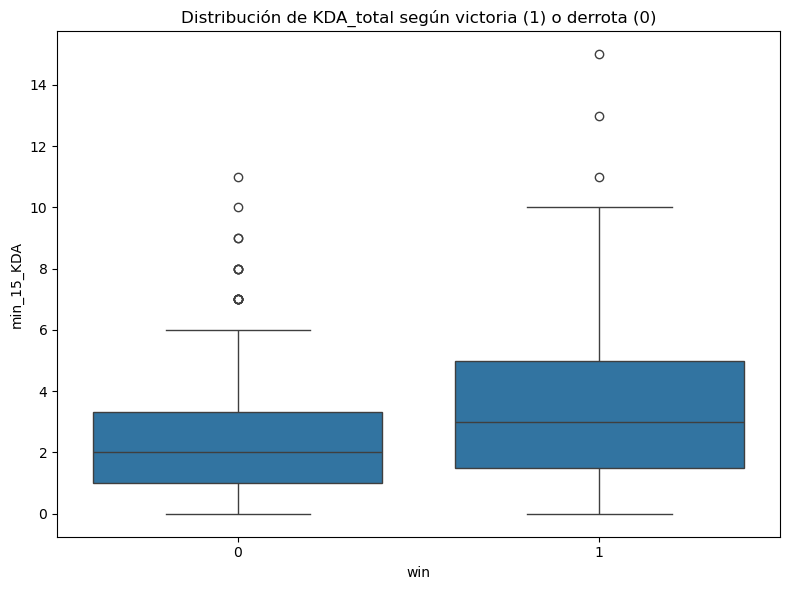

In [14]:
# Lógica: Graficamos Boxplot de wins según KDA de la partida 
# Objetivo: Visualizar como distribuyen dependiendo de si se gana o se pierde la partida.
plt.figure(figsize=(8,6))
sns.boxplot(data=df_analytics, x='win', y='min_15_KDA')
plt.ylabel('min_15_KDA')
plt.title("Distribución de KDA_total según victoria (1) o derrota (0)")

plt.tight_layout()
plt.show()

**Observación:**

Vemos una clara diferencia en cómo influye el KDA al min 15 respecto al target. El KDA es mayor en las victorias. Para estar de si existe una relevancia estadística seguro haré un análisis estadístico.

In [15]:
# 1. Test para conjunto de partidas FLEX
print ('Test para conjunto de partidas FLEX:')

# Test de hipótesis para corroborar si KDA influye en las win cuando en games flex
stat_vs_per_min,p_valor_vs_per_min =  test_mann_whitney(
    df_analytics_flex,
    'min_15_KDA',
    'win',
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

# 2. Test para conjunto de partidas Solo Q
print ('Test para conjunto de partidas Solo Q:')

# Test de hipótesis para corroborar si KDA influye en las win cuando en games soloQ
stat_vs_per_min,p_valor_vs_per_min =  test_mann_whitney(
    df_analytics_soloq,
    'min_15_KDA',
    'win',
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.01,
    alternative='greater')

# 3. Test para todas las partidas.
print ('Test para todas las partidas:')

# Test de hipótesis para corroborar si KDA influye en las win
stat_vs_per_min,p_valor_vs_per_min =  test_mann_whitney(
    df_analytics,
    'min_15_KDA',
    'win',
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.01,
    alternative='greater')

Test para conjunto de partidas FLEX:
📊 TEST MANN-WHITNEY: 'min_15_KDA' por 'win'
   H1 (Hipótesis Alternativa): Grupo '1' es MAYOR que Grupo '0'
   ✅ RESULTADO SIGNIFICATIVO (p < 0.05)
   -> Se rechaza la Hipótesis Nula (H0).
   -> Hay evidencia de que 'min_15_KDA' es MAYOR en el grupo '1'.
------------------------------------------------------------

Test para conjunto de partidas Solo Q:
📊 TEST MANN-WHITNEY: 'min_15_KDA' por 'win'
   H1 (Hipótesis Alternativa): Grupo '1' es MAYOR que Grupo '0'
   ✅ RESULTADO SIGNIFICATIVO (p < 0.01)
   -> Se rechaza la Hipótesis Nula (H0).
   -> Hay evidencia de que 'min_15_KDA' es MAYOR en el grupo '1'.
------------------------------------------------------------

Test para todas las partidas:
📊 TEST MANN-WHITNEY: 'min_15_KDA' por 'win'
   H1 (Hipótesis Alternativa): Grupo '1' es MAYOR que Grupo '0'
   ✅ RESULTADO SIGNIFICATIVO (p < 0.01)
   -> Se rechaza la Hipótesis Nula (H0).
   -> Hay evidencia de que 'min_15_KDA' es MAYOR en el grupo '1'.
-----

**Observaciones sobre KDA**

**1. Análisis general:**
- Confirmamos lo revisado en la distribución, se encontró una **fuerte significancia estadística ($p < 0.05$ en Flex y $p < 0.01$ en SoloQ)** para la *KDA* (`min_15_KDA`) para ambos tipos de cola.

**Revisión**

Revisamos tanto el promedio de wards colocados minuto como la puntuación de visión por minuto. Con dichos datos verificar si el promedio de ambas métricas es estadísticamente relevante en las victorias de mis partidas.

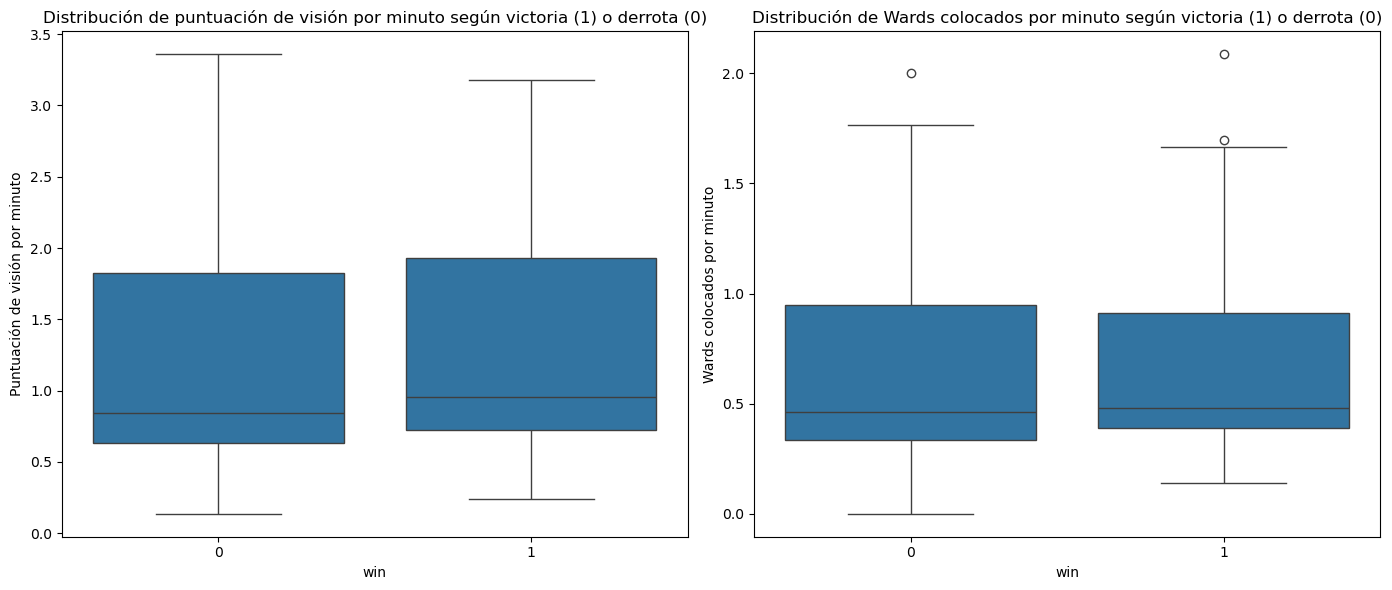

In [16]:
# Lógica: Graficamos Boxplot de wins según vision score y wards por minutos  
# Objetivo: Visualizar como distribuyen dependiendo de si se gana o se pierde la partida.
plt.figure(figsize=(14,6))

# --- Subplot 1 ---
plt.subplot(1, 2, 1)
sns.boxplot(data=df_analytics, x='win', y='vs_per_min')
plt.ylabel('Puntuación de visión por minuto')
plt.title("Distribución de puntuación de visión por minuto según victoria (1) o derrota (0)")

# --- Subplot 2 ---
plt.subplot(1, 2, 2)
sns.boxplot(data=df_analytics, x='win', y='wards_per_min')
plt.ylabel('Wards colocados por minuto')
plt.title("Distribución de Wards colocados por minuto según victoria (1) o derrota (0)")

plt.tight_layout()
plt.show()

**Observación**

A simple vista pareciera haber una diferencia en ambas métricas respecto al target (especialmente en el vision score). Sin embargo, esto no es suficiente, por lo que es necesario un análisis estadístico para estar seguro de si existen una relevancia estadística y detectar si la puntuación de visión por minuto y la cantidad de wards por minutos es significante en las victorias.

Haré un test filtrando por tipo de partida con el fin de detectar si las variables cambian su comportamiento según si es solo Q o flex.

In [17]:
# 1. Test para conjunto de partidas FLEX
print ('Test para conjunto de partidas FLEX:')

# Test de hipótesis para corroborar si vs_per_min influye en las win cuando en games flex
stat_vs_per_min,p_valor_vs_per_min =  test_mann_whitney(
    df_analytics_flex,
    'vs_per_min','win',
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

# Test de hipótesis para corroborar si vs_per_min influye en las win cuando en games flex
stat_wards_per_min,p_valorwards_per_min =  test_mann_whitney(
    df_analytics_flex,
    'wards_per_min',
    'win', 
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

# 2. Test para conjunto de partidas Solo Q
print ('Test para conjunto de partidas Solo Q:')

# Test de hipótesis para corroborar si vs_per_min influye en las win cuando en games soloQ
stat_vs_per_min,p_valor_vs_per_min =  test_mann_whitney(
    df_analytics_soloq,
    'vs_per_min','win',
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

# Test de hipótesis para corroborar si vs_per_min influye en las win cuando en games soloQ
stat_wards_per_min,p_valorwards_per_min =  test_mann_whitney(
    df_analytics_soloq,
    'wards_per_min',
    'win', 
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

# 3. Test para todas las partidas.
print ('Test para todas las partidas:')

# Test de hipótesis para corroborar si vs_per_min influye en las win
stat_vs_per_min,p_valor_vs_per_min =  test_mann_whitney(
    df_analytics,
    'vs_per_min','win',
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

# Test de hipótesis para corroborar si vs_per_min influye en las win
stat_wards_per_min,p_valorwards_per_min =  test_mann_whitney(
    df_analytics,
    'wards_per_min',
    'win', 
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

Test para conjunto de partidas FLEX:
📊 TEST MANN-WHITNEY: 'vs_per_min' por 'win'
   H1 (Hipótesis Alternativa): Grupo '1' es MAYOR que Grupo '0'
   ❌ NO SIGNIFICATIVO (p >= 0.05)
   -> No se puede rechazar la Hipótesis Nula (H0).
   -> No hay evidencia suficiente para afirmar la relación planteada.
------------------------------------------------------------

📊 TEST MANN-WHITNEY: 'wards_per_min' por 'win'
   H1 (Hipótesis Alternativa): Grupo '1' es MAYOR que Grupo '0'
   ✅ RESULTADO SIGNIFICATIVO (p < 0.05)
   -> Se rechaza la Hipótesis Nula (H0).
   -> Hay evidencia de que 'wards_per_min' es MAYOR en el grupo '1'.
------------------------------------------------------------

Test para conjunto de partidas Solo Q:
📊 TEST MANN-WHITNEY: 'vs_per_min' por 'win'
   H1 (Hipótesis Alternativa): Grupo '1' es MAYOR que Grupo '0'
   ❌ NO SIGNIFICATIVO (p >= 0.05)
   -> No se puede rechazar la Hipótesis Nula (H0).
   -> No hay evidencia suficiente para afirmar la relación planteada.
-------------

**Observaciones sobre la Visión**

1. **Flex:**
- Se rechaza la hipótesis de que la puntuación de visión influye en la victoria ($p > 0.05$).
  - La puntuación de visión no es la variable que diferencia las victorias de las derrotas en este entorno. Es necesario evaluar si la colocación de visión es óptima, dado que en Solo Q si es significativo. También es importante analizar las variables de combate directo (KDA u oro) y revisar si muestran la significancia estadística que la visión no tuvo.
- Se aprueba la hipótesis de que la cantidad de visión influye en la victoria ($p > 0.05$).
  - La cantidad de visión es una variable que diferencia las victorias de las derrotas en Flex. Puede que la cantidad de wards esté cubriendo la deficiente calidad, por lo que wards ineficientes son significativos pero la puntuación de visión no.

2.  **Solo Q:**
- Se rechaza la hipótesis de que la puntuación de visión y la cantidad de visión influye en la victoria ($p > 0.05$).
  - En el caso de SoloQ, no estoy colocando centinelas y mucho menos buenos centinelas, por lo que ambos factores en esta cola no se inciden en la victoria.

3. **Análisis general:**
- Sin embargo, se encontró una **fuerte significancia estadística ($p < 0.05$)** para la *Calidad de Visión* (`vs_per_min`) y para la *Cantidad de visión* (`wards_per_min`).
  - Analizando los datos en conjunto toma como aprobadas las dos hipotesis. Tanto la cantidad como la calidad de visión es significativo para la victoria.

## Análisis del jugador: VISION BENCHMARK - Rendimiento actual vs liga superior e inferior

Basándonos en las estadísticas recopiladas por **LEAGUE OF GRAPHS**, podemos obtener difentes métricas de las partidas de todas las ligas de League of Legends. Es en relación a dichas métricas que podemos comparar el rendimiento promedio de los jugadores de diferentes ligas con el propio.

** Para obtener la cantidad de wards por minuto utilicé el tiempo promedio de una partida de league of legends (30 minutos).

In [18]:
# Lógica = Obtenemos el promedio wards_per_min por rol
# Obejtivo = Usar esta métrica en el análisis descriptivo
wpm_flex = df_analytics_flex.groupby('role')['wards_per_min'].mean().round(2)
wpm_flex = pd.DataFrame(wpm_flex).rename(columns={'wards_per_min':'my_wpm_flex'})
wpm_soloQ = df_analytics_soloq.groupby('role')['wards_per_min'].mean().round(2)
wpm_soloQ = pd.DataFrame(wpm_soloQ).rename(columns={'wards_per_min':'my_wpm_soloQ'})
stats = pd.concat([wpm_soloQ,wpm_flex],axis=1)
stats = pd.DataFrame(stats)


# Datos de promedio wards_per_min por rol sacados de League of Graphs (Diamante y Master)
total_wards_diamond = {
    'TOP': 9.3,
    'JUNGLE': 5.5,
    'MIDDLE': 10,
    'BOTTOM': 9.5,
    'UTILITY': 29.5
}

total_wards_master = {
    'TOP': 8.8,
    'JUNGLE': 5.2,
    'MIDDLE': 9.4,
    'BOTTOM': 9.1,
    'UTILITY': 29.5
}
# Dataframe de mean_wards_master diamante
benchmark_diamond = pd.DataFrame.from_dict(
    total_wards_diamond, 
    orient='index', 
    columns=['mean_wards_diamond']
)

# Dataframe de mean_wards_master master
benchmark_master = pd.DataFrame.from_dict(
    total_wards_master, 
    orient='index', 
    columns=['mean_wards_master']
)

# Obtiene el "Total" de "Wards por Minuto" estimado
STANDARD_DURATION = 30
benchmark_diamond['wpm_diamond'] = (benchmark_diamond['mean_wards_diamond'] / STANDARD_DURATION).round(2)
benchmark_master['wpm_master'] = (benchmark_master['mean_wards_master'] / STANDARD_DURATION).round(2)

# Une los set de datos (mi data vs data diamante vs data master).
df_benchmark = pd.concat([benchmark_diamond,benchmark_master,stats],axis=1)
df_benchmark = df_benchmark.drop(columns= ['mean_wards_diamond','mean_wards_master'])
df_benchmark

,wpm_diamond,wpm_master,my_wpm_soloQ,my_wpm_flex
TOP,0.31,0.29,0.39,0.45
JUNGLE,0.18,0.17,0.29,0.33
MIDDLE,0.33,0.31,0.51,NaN
BOTTOM,0.32,0.30,0.43,0.42
UTILITY,0.98,0.98,1.02,1.33


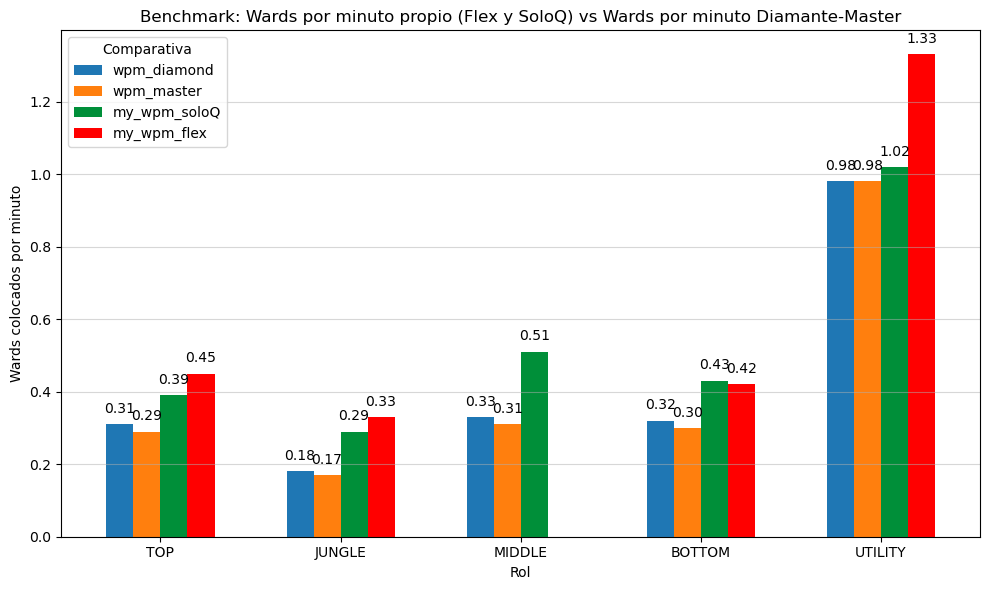

In [19]:
# Graficamos el benchmark

ax = df_benchmark.plot(
    kind='bar',
    figsize=(10, 6),
    width=0.6,   
    color=['#1f77b4', '#ff7f0e', '#008f39', '#ff0000']
)

plt.title('Benchmark: Wards por minuto propio (Flex y SoloQ) vs Wards por minuto Diamante-Master')
plt.ylabel('Wards colocados por minuto')
plt.xlabel('Rol')
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=0)
plt.legend(title='Comparativa')

# Etiquetas mejoradas
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom',
            xytext=(0, 6),  
            textcoords='offset points'
        )

plt.tight_layout()
plt.show()

**Observación**

- **Flex:** Se observa una ineficiencia de la visión. El volumen de centinelas colocados supera el estándar de liga actual (diamante) y de la siguiente (master) en todos los roles jugados. A pesar de genera impacto estadístico en el resultado de las partidas (cantidad de wards) se está invirtiendo demasiado oro en visión innecesaria La estrategia óptima es reducir el volumen de compra para liberar recursos hacia variables con mayor correlación potencial (KDA/oro).

- **Solo Q (Top/Jg/Bot)**: Se mantiene el patrón de exceso vs el elo actual y el superior, pero  existe evidencia estadística que la eficiencia (vision_score) incide en las victorias. Se recomienda de igual manera reducir cantidad y priorizar calidad.

- **Solo Q (Soporte):** Es la única excepción. Tu volumen (1) ronda el estándar de Diamante y Master (0.98). Al ser la visión estadísticamente significativa en SoloQ, esta métrica está muy bien.

## Análisis del jugador:  Ventaja de visión sobre el adversario

In [20]:
ventaja_vision = df_analytics.groupby('role')['vision_advantage'].agg(['mean'])
ventaja_vision

,mean
role,
BOTTOM,0.070995
JUNGLE,0.150138
MIDDLE,0.120697
TOP,0.272902
UTILITY,0.061950


**Observación**

En todos los roles tienes mejor puntuación de visión que tu rival, eso está bien. Sin embargo, vigila las diferencias excesivas para evitar sobregasto en visión innecesaria.

## Análisis del jugador:  Primera torre y primer heraldo.

In [21]:
first_tower_stats = df_analytics.groupby(['queue_id','first_rift_herald','first_tower'])['win'].agg(['mean'])
first_tower_stats['mean'] = first_tower_stats['mean'].round(2)
first_tower_stats

mean
queue_id first_rift_herald first_tower      
420      0                 0            0.21
                           1            0.44
         1                 0            0.53
                           1            0.73
440      0                 0            0.17
                           1            0.58
         1                 0            0.48
                           1            0.76

**Observaciones**

**1. SoloQ**
- Primer heraldo (True) y Primera Torre (True): Detectamos que los juegos en los que se tira primera torre y se obtiene primer heraldo se ganan en un 73%.
- Primer heraldo (False) y Primera Torre (False): Detectamos que los juegos en los que no se tira primera torre y no se obtiene primer heraldo se ganan un 21%.

**Recomendación:** Con tan solo obtener el heraldo, la probabilidad de victoria asciende a un 53%. Con obtener ambos objetivos asciende a un 80%. La prioridad máxima es obtener estos dos objetivos, dado que es una victoria casi segura.

**1. Flex**
- Primer heraldo (True) y Primera Torre (True): Detectamos que los juegos en los que se tira primera torre y se obtiene primer heraldo se ganan en un 76%.
- Primer heraldo (False) y Primera Torre (False): Detectamos que los juegos en los que no se tira primera torre y no se obtiene primer heraldo se ganan un 17%.

**Recomendación:** Al igual que en cola Solo Q, obtener ambos objetivos asciende a un 76% el win rate. La prioridad máxima es obtener estos dos objetivos.

## Análisis del jugador:  W/R por rol y por campeón (análisis champeon pool)

Revisamos la cantidad de juegos ganados por rol y por campeón con el fin de obtener información de cuáles son mis mejores roles y campeones en relación a la cantidad de partridas ganadas (análisis general, en partidas Solo Q y Flexible). De esta forma, analizar si mis roles y champs mains están siendo efectivos.

In [22]:
# Agrupamos por rol y calculamos suma (wins) y cuenta (total de partidas en el rol)
wr_per_rol_general = df_analytics.groupby('role')['win'].agg(['sum', 'count'])
wr_per_rol_flex = df_analytics_flex.groupby('role')['win'].agg(['sum', 'count'])
wr_per_rol_soloq = df_analytics_soloq.groupby('role')['win'].agg(['sum', 'count'])

# Renombramos columnas para mayor legibilidad
wr_per_rol_general = wr_per_rol_general.rename(columns={'sum':'Victorias','count':'Total_Partidas'})
wr_per_rol_flex = wr_per_rol_flex.rename(columns={'sum':'Victorias','count':'Total_Partidas'})
wr_per_rol_soloq = wr_per_rol_soloq.rename(columns={'sum':'Victorias','count':'Total_Partidas'})

# Creamos columna del win rate por rol según el tipo de cola y en general
wr_per_rol_general['WR_per_role_general'] = (wr_per_rol_general['Victorias'] / wr_per_rol_general['Total_Partidas']).round(2)
wr_per_rol_flex['WR_per_role_flex'] = (wr_per_rol_flex['Victorias'] / wr_per_rol_flex['Total_Partidas']).round(2)
wr_per_rol_soloq['WR_per_role_soloq'] = (wr_per_rol_soloq['Victorias'] / wr_per_rol_soloq['Total_Partidas']).round(2)

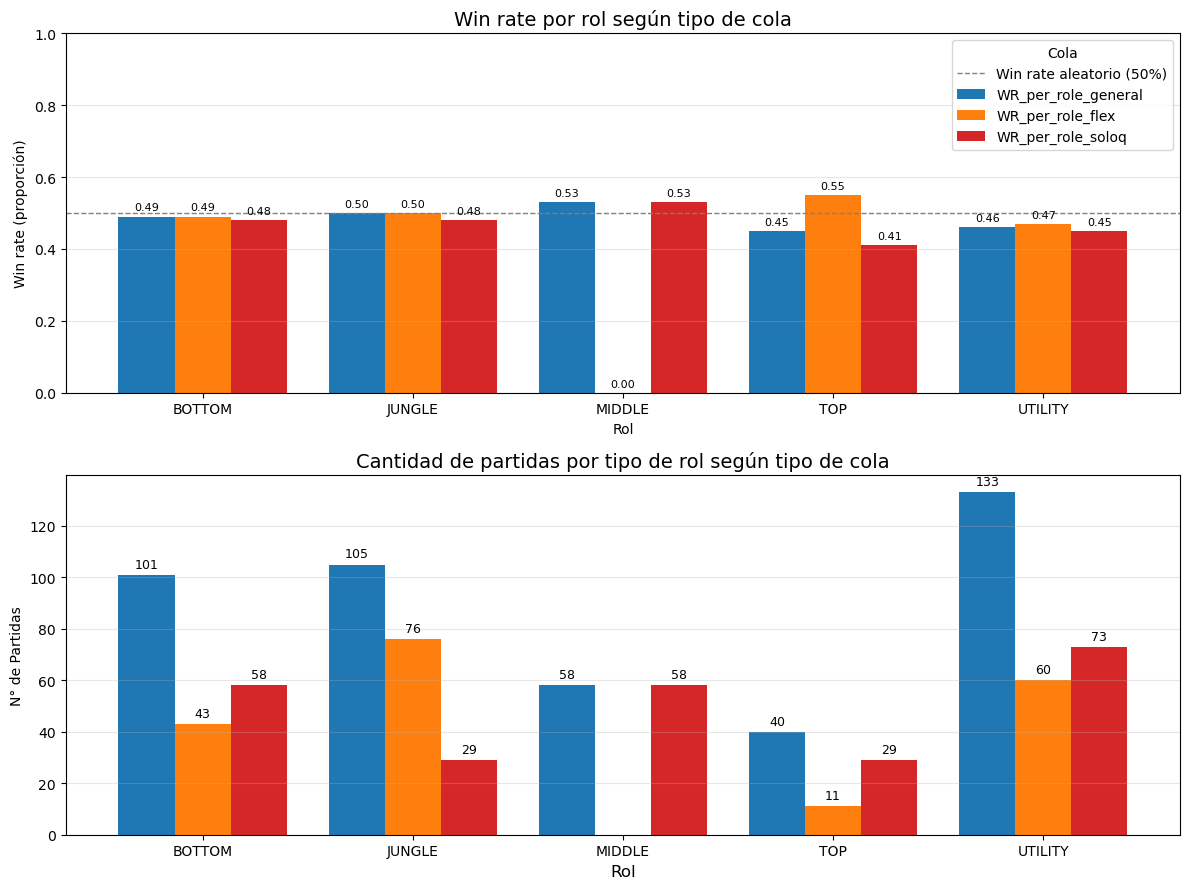

In [23]:
wr_analytics = pd.concat([
    wr_per_rol_general['WR_per_role_general'],
    wr_per_rol_flex['WR_per_role_flex'],
    wr_per_rol_soloq['WR_per_role_soloq']],
    axis = 1)
    
fig, ax = plt.subplots(2, 1, figsize=(12, 9))

# Gráfico win ratio por rol por tipo de cola
wr_analytics.plot(
    kind='bar',
    width=0.8,
    color=['#1f77b4', '#ff7f0e', '#d62728'],
    ax=ax[0] # Directo al primer eje
)

# Formato y Etiquetas para ax[0]
ax[0].set_ylim(0.0, 1.0) # Corrección Crítica
ax[0].axhline(0.5, color='gray', linestyle='--', linewidth=1, label='Win rate aleatorio (50%)')
ax[0].set_title('Win rate por rol según tipo de cola', fontsize=14)
ax[0].set_ylabel('Win rate (proporción)')
ax[0].set_xlabel('Rol')
ax[0].tick_params(axis='x', rotation=0) 
ax[0].grid(axis='y', alpha=0.3)
ax[0].legend(title='Cola')

# Anotaciones sobre barras para ax[0]
for p in ax[0].patches:
    height = p.get_height()
    ax[0].annotate(
        f"{height:.2f}", 
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom',
        xytext=(0, 3), 
        textcoords='offset points', 
        fontsize=8
    )

count_analytics = pd.concat([
    wr_per_rol_general['Total_Partidas'],
    wr_per_rol_flex['Total_Partidas'],
    wr_per_rol_soloq['Total_Partidas']],
    axis = 1)

# Gráfico total de partidas por rol
count_analytics.plot(kind='bar', width=0.8, color=['#1f77b4', '#ff7f0e', '#d62728'], ax=ax[1])

# Configuración Eje 2
ax[1].set_title('Cantidad de partidas por tipo de rol según tipo de cola', fontsize=14)
ax[1].set_ylabel('N° de Partidas')
ax[1].set_xlabel('Rol', fontsize=12)
ax[1].tick_params(axis='x', rotation=0)
ax[1].grid(axis='y', alpha=0.3)
ax[1].get_legend().remove() # Quitamos leyenda repetida (ya está arriba)

# Etiquetas de datos (Enteros sin decimales)
for p in ax[1].patches:
    height = p.get_height()
    if height > 0:
        ax[1].annotate(f"{int(height)}", 
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', xytext=(0, 3), 
                       textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

In [24]:
# Creamos una columna para ver el win ratio de cada campeón según el rol que fui
champ_stats_flex = df_analytics_flex.groupby(['champion', 'role'])['win'].agg(['sum', 'count'])
champ_stats_soloq = df_analytics_soloq.groupby(['champion', 'role'])['win'].agg(['sum', 'count'])
champ_stats_general = df_analytics.groupby(['champion', 'role'])['win'].agg(['sum', 'count'])

# 2. Renombrar columnas para claridad
champ_stats_flex.columns = ['Victorias', 'Total_Partidas']
champ_stats_soloq.columns = ['Victorias', 'Total_Partidas']
champ_stats_general.columns = ['Victorias', 'Total_Partidas']

# 3. FILTRO DE RELEVANCIA (Crucial)
# Eliminamos combinaciones raras (ej: jugaste 1 vez Yasuo soporte).
# Filtramos campeones con menos de 5 partidas en ese rol específico.
champ_stats_general = champ_stats_general[champ_stats_general['Total_Partidas'] >= 10] # 5 Revisar campeones con buena proyección
champ_stats_flex = champ_stats_flex[champ_stats_flex['Total_Partidas'] >= 10]
champ_stats_soloq = champ_stats_soloq[champ_stats_soloq['Total_Partidas'] >= 10] 

# 4. Calcular Win Rate
champ_stats_flex['Win_Rate_flex'] = (champ_stats_flex['Victorias'] / champ_stats_flex['Total_Partidas']).round(2)
champ_stats_soloq['Win_Rate_soloq'] = (champ_stats_soloq['Victorias'] / champ_stats_soloq['Total_Partidas']).round(2)
champ_stats_general['Win_Rate_general'] = (champ_stats_general['Victorias'] / champ_stats_general['Total_Partidas']).round(2)

# 5. Ordenar para el Análisis
# Ordenamos por Total para ver tus "Mains" primero.
champ_stats_flex = champ_stats_flex.sort_values(['Total_Partidas'], ascending=[False])
champ_stats_soloq = champ_stats_soloq.sort_values(['Total_Partidas'], ascending=[False])
champ_stats_general = champ_stats_general.sort_values(['Total_Partidas'], ascending=[False])

# Visualización
print("--- Stats generales ---")
print(champ_stats_general)
print("-"*60)
print("\n")
print("--- Stats Flex ---")
print(champ_stats_flex)
print("-"*60)
print("\n")
print("--- Stats Solo Q ---")
print(champ_stats_soloq)

--- Stats generales ---
                     Victorias  Total_Partidas  Win_Rate_general
champion    role                                                
Thresh      UTILITY         29              54              0.54
Sejuani     JUNGLE          29              50              0.58
Trundle     JUNGLE          14              33              0.42
Elise       UTILITY         16              32              0.50
Ezreal      BOTTOM          12              24              0.50
Ahri        MIDDLE          12              23              0.52
Vayne       BOTTOM          11              22              0.50
Smolder     BOTTOM           9              21              0.43
Trundle     TOP              8              16              0.50
Malzahar    MIDDLE           8              15              0.53
MissFortune BOTTOM           7              15              0.47
Leblanc     MIDDLE           8              14              0.57
Blitzcrank  UTILITY          5              11              0.45
B

**Observación W/R de rol** y **W/R de campeones**

- **Rol Jungla**: Jungla ha sido el rol principal en Flex con 76 games (Solo Q tiene solo 29 games). El win ratio general está en un 50%, es rol en donde tu rendimiento no incides, solo dependes de tu equipo o del azar.
  
- **Champeon pool jungla:**

   - **Trundle**: En SoloQ tienen un w/r del 59%, mientras que en Flex es del 25%, lo que baja ratio de victorias general a un 42%. Es decir, reduce significativamente el win ratio de victorias del rol. Que este campeón tenga mejor rendimiento en Solo Q que en Flex puede deberse a que tengo un peor rendimiento en jugadas coordinadas o peleas de equipo.
 
   - **Sejuani**: En Flex tiene un w/r de 59% en 49 partidas (más del doble de partidas que con Trundle en SoloQ), lo que es un pick de alto valor para Flexible. Puede deberse a un mejor rendimiento en peleas de equipo y jugadas coordinadas.
 
- **Accionable para el rol de jungla:** En caso de ir rol de jungla en Solo Q, usar preferiblemente a Trundle (y dejar de usarlo en Flex debido a su mal rendimiento). En Flex mantener el picks de ***Sejuani*** dado su óptimo rendimiento.
---

- **Rol TOP**: Es el rol con mejor win rate en flex (55% w/r) pero muy baja cantidad de partidas (11). El win ratio general llega solo al 45%. Esto quiere decir que es un rol con buena proeycciión para jugar en flex, pero una mala elección para Solo Q, dado que solo baja el win ratio general.

- **Champeon pool TOP:**
   - **Trundle**: Este pick es una ruleta, es completamente azar ganar o perder si lo juegas en top. Evítalo a toda costa.
     
- **Accionable para el rol de TOP:** Deja de jugar top en SoloQ (especialmente Trundle). Prioriza este rol solo en Flex y comienza a practicar otros campeones en meta y que sean sencillos de utilizar como Malphite.

---

- **Rol Soporte:** Es el rol con peor win ratio en Flex como en Solo Q (45% y 47% w/r), lo que indica que es el rol con peor impacto en partidas flexibles y de SoloQ.

  - **Champeon pool Soporte:**
 
  - **Elise**: El pésimo rendimiento en soporte se debe principalmente a este pick. Es puro azar y tienes 32 partidas con este campeon. Jugarlo es depender netamente de tu equipo.

  - **Thresh**: Dentro del mal rendimiento en soporte, el pick que sube tu win ratio es este campeón. Tiene un w/r excelente de 58% en SoloQ. Es mucho mejor que el ratio de victorias de Braum, Blitzcrank o Elise. Si vas a jugar soporte, juega este campeón.
  
- **Accionable para el rol de Soporte:** Deja de jugar soporte en Flex, tu aporte es inutil, mantén los esfuerzos en otros roles y, solo si sales por comodín, usa Thresh. Por otro lado, en SoloQ, juega Thresh y prueba campeones similares, es el campeón con mejor rendimiento junto con Sejuani en Flex

---
 
- **Rol ADC:** El rol tiene win ratio del 50%, jugar este rol sin los campeones adecuados es puramente azar para ganar.

  - **Champeon pool ADC:**

  - **Vayne y Smolder**: Jugar este campeon es dejar la partida al azar. No es recomendable usarlo, solo sutuacionalmente.
 
  - **Ezreal**: A pesar de tener mal win ratio en general en el rol, con Ezreal tienes un buen rendimiento de ADC (56% w/r en Flex), si vas a jugar ADC, juega Ezreal, pero unicamente en Flex, en Solo Q no jugues ADC, no incides realmente en la partida.
    

- **Accionable para el rol de ADC:** Solo juega Ezreal. No uses ninguna otra opcion. En caso de existir muchos tanques, rota a Vayne o Smolder, que si bien son un picks arriesgados, son buenos contra tankes, mientras que Ezreal no es efectivo contra ellos.
---

- **Rol MID:** No hay evidencia suficiente para evaluar este rol en Flex, pero si tiene un 53% de win rate en Solo Q en casi 60 partidas. A pesar de no ser tu rol main, es el rol que tiene el mejor wen rate en general. Esto es una buena proyección, debes jugar y practicar más este rol.

  - **Le Blanc**: Este campeon tiene un win ratio altísimo en 14 juegos. Si bien es un asesino y puede decaer en late game, es un campeón que tiene buena proyección, si comienzas a jugar más mid, este campeón debe estar en tu champion pool.
  
  - **Ahri y Malzahar**: Ambos campeones tienen un win ratio positivo y son campeones "safe" y aportar mucho al equipo, masterizarlos puede significar un mayor win ratio en el Rol de mid

- **Accionable para el rol de MID:**  Evalua jugar más en mid y evalúa las métricas que obtengas. Sigue jugando a Leblanc, Malzahar y Ahri en SoloQ..

---
**KPI - Win Rate:**

- Mantener un Win Rate del "Champion Pool" de cada rol > 55%.

- Cualquier campeón con >20 partidas y <48% WR se considera "Incompatible" y se elimina de la rotación competitiva.


## Análisis comportamiento del sistema: Elasticidad y "Loss Q" (corrección de MMR)

Más allá del rendimiento individual por campeón, es crítico analizar el comportamiento del algoritmo de emparejamiento (Matchmaking), dado que el rendimiento del campeón no solo depende de mi, si no también lo que puede suceder en factores agenos.

El Objetivo: Investigar estadísticamente la existencia de patrones de corrección forzada (coloquialmente conocidos como "Losers Queue"). Se busca determinar si el sistema impone una resistencia artificial tras rachas de victorias para forzar una regresión al 50% de Win Rate.

**¿El estancamiento en la liga se debe a un límite de habilidad personal o a un techo artificial generado por algorítmo que penaliza las rachas positivas?**

### Elasticidad Partidas Flex

In [25]:
# 1. Identificador de rachas y racha actual por partida.
# Creamos un agrupador de rachas y asignamos un identificador (comienza en 1). 
# Si el resultado actual es distinto al anterior, empieza nueva racha, por lo tanto, un nuevo identificador.
df_analytics_flex['streak_group'] = (df_analytics_flex['win'] != df_analytics_flex['win'].shift(1)).cumsum()
df_analytics_flex['streak_counter'] = df_analytics_flex.groupby('streak_group').cumcount() + 1


# Obtenemos la racha actual y determinamos si es racha de derrotas o de victorias
# Multiplica por 1 o -1. Cuando se gana se deja como racha de victorias (1,2,3...), cuando no, como derrotas (-1,-2,-3...). }
df_analytics_flex['racha_actual'] = np.where(
    df_analytics_flex['win'] == 1, 
    df_analytics_flex['streak_counter'],      # Caso Win: 3
    df_analytics_flex['streak_counter'] * -1  # Caso Loss: -3
)

# Hacemos lo mismo para SoloQ
# Identificador de racha
df_analytics_soloq['streak_group'] = (df_analytics_soloq['win'] != df_analytics_soloq['win'].shift(1)).cumsum()
df_analytics_soloq['streak_counter'] = df_analytics_soloq.groupby('streak_group').cumcount() + 1

# Racha actual
df_analytics_soloq['racha_actual'] = np.where(
    df_analytics_soloq['win'] == 1, 
    df_analytics_soloq['streak_counter'],      # Caso Win: 3
    df_analytics_soloq['streak_counter'] * -1  # Caso Loss: -3
)

# Creamos la columna racha previa para tener la racha sin considerar la partida actual
# Crear "racha previa" da contexto sin reiterar información de victoria.
df_analytics_soloq['racha_previa'] = df_analytics_soloq['racha_actual'].shift(1).fillna(0).astype(int)
df_analytics_flex['racha_previa'] = df_analytics_flex['racha_actual'].shift(1).fillna(0).astype(int)
 
# 2. Predecir el FUTURO (Target Leakage intencional para análisis)
# Queremos saber: "Dada mi racha actual, ¿gané la SIGUIENTE?"
df_analytics_flex['next_game_win'] = df_analytics_flex['win'].shift(-1)
df_analytics_soloq['next_game_win'] = df_analytics_soloq['win'].shift(-1)

# Para graficar
# Agrupamos por la racha actual y obtenemos el promedio de ganar la siguiente partida y la frecuencia de las racha. 
streak_stats_flex = df_analytics_flex.groupby('racha_actual')['next_game_win'].agg(['mean', 'count'])
streak_stats_flex = streak_stats_flex[streak_stats_flex['count'] >= 5].round(2) # Mínimo 5 casos para que sea estadísticamente válido
                 
streak_stats_soloq = df_analytics_soloq.groupby('racha_actual')['next_game_win'].agg(['mean', 'count'])
streak_stats_soloq = streak_stats_soloq[streak_stats_soloq['count'] >= 5].round(2) 

--- Probabilidad de ganar la siguiente partida según la racha actual (Flex)---
              mean  count
racha_actual             
-4            0.80      5
-3            0.62     13
-2            0.44     25
-1            0.52     52
 1            0.49     51
 2            0.44     25
 3            0.36     11


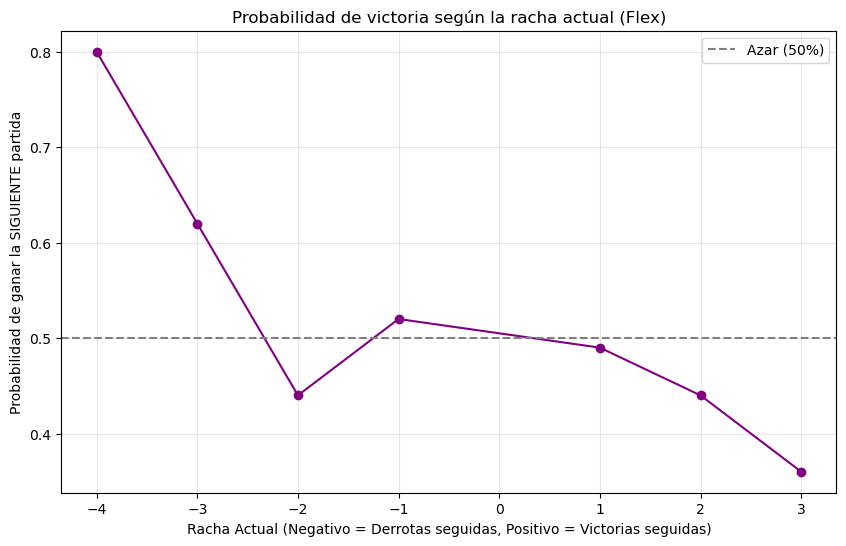

In [26]:
# Graficamos los datos obtenidos

print("--- Probabilidad de ganar la siguiente partida según la racha actual (Flex)---")
print(streak_stats_flex)

plt.figure(figsize=(10, 6))
plt.plot(streak_stats_flex.index, streak_stats_flex['mean'], marker='o', linestyle='-', color='purple')
plt.axhline(0.5, color='gray', linestyle='--', label='Azar (50%)')
plt.title('Probabilidad de victoria según la racha actual (Flex)')
plt.xlabel('Racha Actual (Negativo = Derrotas seguidas, Positivo = Victorias seguidas)')
plt.ylabel('Probabilidad de ganar la SIGUIENTE partida')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### Elasticidad Partidas Solo Q

--- Probabilidad de ganar la siguiente partida según la racha actual (SoloQ)---
              mean  count
racha_actual             
-4            0.33      6
-3            0.50     14
-2            0.58     33
-1            0.51     67
 1            0.42     66
 2            0.50     28
 3            0.43     14
 4            0.67      6


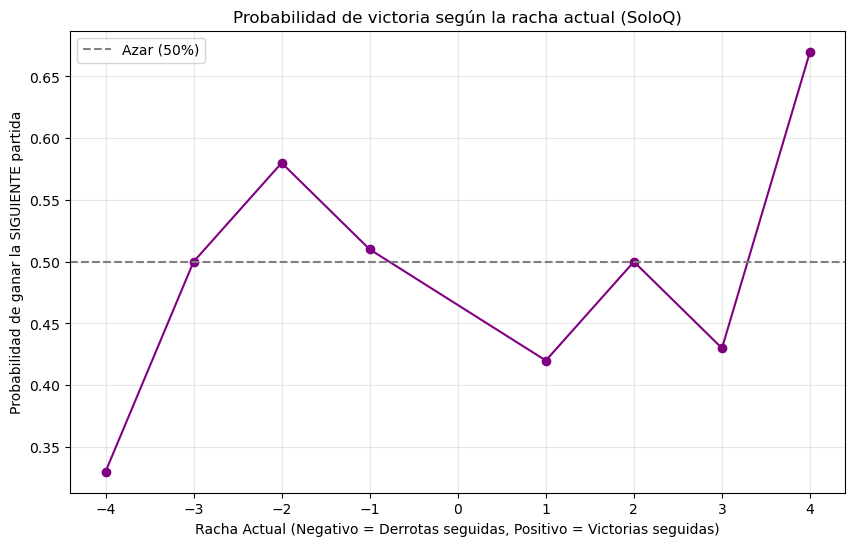

In [27]:
# Graficamos los datos obtenidos

print("--- Probabilidad de ganar la siguiente partida según la racha actual (SoloQ)---")
print(streak_stats_soloq)

plt.figure(figsize=(10, 6))
plt.plot(streak_stats_soloq.index, streak_stats_soloq['mean'], marker='o', linestyle='-', color='purple')
plt.axhline(0.5, color='gray', linestyle='--', label='Azar (50%)')
plt.title('Probabilidad de victoria según la racha actual (SoloQ)')
plt.xlabel('Racha Actual (Negativo = Derrotas seguidas, Positivo = Victorias seguidas)')
plt.ylabel('Probabilidad de ganar la SIGUIENTE partida')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

**Observaciónes: El dilema de la racha de 3**

Logramos detectar claramente una tendencia que, luego de una racha de 3 victorias -tanto en Flex como Solo Q-, las probabilidades de ganar una cuarta partida son de máxmimo un 43%. Es decir, ya sea por mi rendimiento o el matchmaking, se corrige el mmr brúscamente luego de una racha de victorias o derrotas. De este modo, puede evitar que subas por factores aleatorios y premia a quien tiene las habilidades necesarias para seguir subiendo de liga.

**La racha de 3 Solo Q:**
La racha de 3 ya sea de derrotas o de victorias es un problema complejo. Si se logra ganar 2 partidas seguidas, ganar una 3ra es prácticamente aleatorio, y pasar a ganar una 4ta partida se tiene tan solo un 43% de w/r. Al menos, existe una especia de salvavida al llegar a las 2 derrotas seguidas, un win rate de un 58%. Sin embargo, si logras perder 3 seguidas, la 4ta es aleatoria y ya en una 5ta es una caida libre (un 33% w/r).

En definitiva, es más sencillo PARA MI salir de una racha de derrotas, que obtener una racha de victorias, dado que con solo haber ganado 1, el win ratio empieza a disminuir.

**La racha de 3 Flex:**
Similar a Solo Q, es más sencillo salir de una racha de derrotas que obtener una racha de victorias. Sin embargo, el salvavidas es mucho más consistente, mientras más pierda, mis chances de ganar son más altas, mientra que en Solo Q solo da 1 oportunidad y si la desaprovechas, es seguir perdiendo casi con seguridad. Por otro lado, obtener una racha de victorias es mucho más dificil, puesto que ganar tiene cada vez peor win rate.


En resumen:
- En Solo Q: **PARA MÍ** la probabilidad de salir de una racha de derrotas es más alta que subir abruptamente. Perder la oportunidad de ganar en una racha de derrotas genera una derrota casi segura.
- En Flex: Para mí existe una especie de "estabilizador", haciendo improbable tanto el ascenso rápido como el descenso brusco.

Por otro lado, es relevante preguntarse: **¿Es el matchmaking el que crea una situación de baja probabilidad de victoria luego de una racha de 3 victorias o es mi rendimiento personal que empeora en una racha de +3 victorias?**


### Matchmaking malévolo o rendimiento inestable luego de +3 victorias.

Al no tener una idea preestablecida de que existe un patron de "la siguiente partida luergo de 3 victorias es un techo de mmr el cual debo romper para seguir ganando", la única manera de poder verificar si pierdo por tilt o por matchmaking es revisar mi rendimiento en juegos que son "bajo presión" (racha +3 victorias) y de juegos que no lo son. De esta manera, si son derrotas aplastantes tiene más sentido que las derrotas en la 4ta partida sea por variables de entorno (emparejamiento) que por tilteo.

In [28]:
# 1. Identificar las "Partidas de Presión" (Cuando vienes de racha +3)
# Usamos la lógica de rachas anterior
# Si racha_previa es 3, significa que gané 1, 2 y 3. Estoy jugando la 4ta.
# Esta partida (la 4ta) es la que tiene el WR de 0.43 en Solo Q
df_analytics_flex['is_MMR_check'] = df_analytics_flex['racha_actual'].shift(1) == 3

# 2. Seleccionar métricas de rendimiento PERSONAL (Que dependen solo de ti)
# No uses 'win' ni 'dragons', usa cosas que controlas tú.
metrics = ['min15_cs_diff', 'min15_gold_diff', 'min15_xp_diff','min15_kills','min15_deaths','min15_assists']

# 3. Comparar Promedios
pressure_analysis_flex = df_analytics_flex.groupby(['is_MMR_check','role'])[metrics].mean()

print("--- Rendimiento Flex: Normal vs Presión (Racha +3) ---")
pressure_analysis_flex

--- Rendimiento Flex: Normal vs Presión (Racha +3) ---


min15_cs_diff  min15_gold_diff  min15_xp_diff  \
is_MMR_check role                                                     
False        BOTTOM      -18.285714      -730.095238    -307.928571   
             JUNGLE      -12.833333      -373.875000    -418.611111   
             TOP         -16.700000        70.200000     410.700000   
             UTILITY       0.163636       -83.636364    -280.872727   
True         BOTTOM      -21.000000      -627.000000    -244.000000   
             JUNGLE       -3.000000       -17.000000      47.750000   
             TOP          30.000000      1080.000000    1073.000000   
             UTILITY       9.200000      -578.000000    -334.000000   

                      min15_kills  min15_deaths  min15_assists  
is_MMR_check role                                               
False        BOTTOM      1.833333      1.642857       1.738095  
             JUNGLE      1.777778      1.555556       3.750000  
             TOP         2.300000      1.300000       0.900000  
             UTILITY     0.909091      1.981818       4.763636  
True         BOTTOM      0.000000      1.000000       0.000000  
             JUNGLE      1.250000      1.000000       4.500000  
             TOP         3.000000      3.000000       0.000000  
             UTILITY     0.800000      2.200000       3.200000

In [29]:
# 1. Identificar las "Partidas de Presión" (Cuando vienes de racha +3)
# Usamos la lógica de rachas anterior (asegúrate de tener 'current_streak' calculado)
df_analytics_soloq['is_MMR_check'] = df_analytics_soloq['racha_actual'].shift(1) == 3

# 2. Seleccionar métricas de rendimiento PERSONAL (Que dependen solo de ti)
# No uses 'win' ni 'dragons', usa cosas que controlas tú.
metrics = ['min15_cs_diff', 'min15_gold_diff', 'min15_xp_diff','min15_kills','min15_deaths','min15_assists']

# 3. Comparar Promedios
pressure_analysis_soloq = df_analytics_soloq.groupby(['is_MMR_check','role'])[metrics].mean()

print("--- Rendimiento Solo Q: Normal vs Presión (Racha +3) ---")
pressure_analysis_soloq

--- Rendimiento Solo Q: Normal vs Presión (Racha +3) ---


min15_cs_diff  min15_gold_diff  min15_xp_diff  \
is_MMR_check role                                                     
False        BOTTOM       -5.981481      -107.925926     -65.388889   
             JUNGLE       -8.846154      -435.538462    -555.923077   
             MIDDLE       -4.000000      -426.418182     -86.309091   
             TOP         -10.892857      -525.285714    -695.928571   
             UTILITY       1.142857       168.457143     -76.357143   
True         BOTTOM       -0.250000       155.000000     668.000000   
             JUNGLE      -13.666667      -855.000000    -915.666667   
             MIDDLE        8.000000      -376.000000    -775.000000   
             TOP           5.000000       979.000000     787.000000   
             UTILITY      -4.666667      -482.666667     118.000000   

                      min15_kills  min15_deaths  min15_assists  
is_MMR_check role                                               
False        BOTTOM      2.759259      2.166667       1.481481  
             JUNGLE      2.000000      2.653846       2.961538  
             MIDDLE      2.109091      1.981818       2.200000  
             TOP         1.821429      3.392857       0.714286  
             UTILITY     1.814286      2.485714       4.514286  
True         BOTTOM      4.250000      2.000000       1.500000  
             JUNGLE      1.000000      1.666667       2.000000  
             MIDDLE      2.333333      3.333333       0.666667  
             TOP         2.000000      2.000000       2.000000  
             UTILITY     3.333333      4.000000       3.333333

### Luego de perder un MMR check, ¿caigo al abismo o es solo un tropiezo?

In [30]:
# Filtramos: Grupos donde hubo 'MMR Check' (1) Y perdiste (0)
# Esto selecciona el ID de todas las rachas de derrotas que empezaron con un check fallido
ids_abismo = df_analytics_soloq.loc[(df_analytics_soloq['is_MMR_check'] == 1) & (df_analytics_soloq['win'] == 0), 'streak_group']

# Resultado: ¿Cuánto duraron esas rachas? (Frecuencia en %)
# Cuenta cuántas partidas tiene cada grupo seleccionado
print(df_analytics_soloq[df_analytics_soloq['streak_group'].isin(ids_abismo)].groupby('streak_group').size().value_counts(normalize=True) * 100)

1    87.5
2    12.5
Name: proportion, dtype: float64


**Observaciones**

Luego de perder un partida de MMR check, por lo general solo pierdes esa partida y luego ganas, es raro (12% de probabilidad) seguir perdiendo luego del mmrcheck.

**Conclusiones**

Tanto en solo Q como en Flex podemos ver una diferencia sustancial entre los juegos "bajo presión" y los que no. 
En esa 4ta partida:

- **ROL ADC:** Tengo casi todo mi rendimiento mejor que el de mi rival en partidas bajo presión, mismo CS, más oro, más XP y buen KDA, por ende, no es un juego tilt mio, sino más bien factores externos como el matchmaking o no supe carrear la partida o ambos sucesos.

- **ROL Jungla**: Tengo un buen KDA, pero el enemigo es mejor que yo farmeando, obteniendo oro y XP. Por ende, no es un juego tilt mio (no estoy muriendo en exceso), sino que el rival es mejor que yo o el matchmaking no fue bueno o no supe carrear la partida (o todo junto).

- **ROL MID**: Tampoco tengo un mal KDA pero el rival me saca ventaja en ORO y en XP (puede ser mejores rotaciones). Al igual que los casos anteriores, no parece ser una partida tilt.

- **ROL TOP**: Al igual que en rol de ADC, mi juego y mi KDA es mejor que el del rival, pero por matchmaking o por no saber carrear el game, no gané la partida.

- **ROL Support:** Muero un poco más que el resto de roles (entendible por el tipo de rol), pero aún asi no es un mal KDA. Siendo soporte es normal morir un poco más. Sin embargo, tampoco pareciera una desventaja gigante ante el rival a diferencia de roles como jungla o mid.

En definitiva, en casi ningun rol estoy teniendo juegos tilt con muertes excesivas pero si diferencias de oro significativas (Jungla, MID y Support). Si esoty teniendo KDA decentes pero perdida en oro, quiere decir que o estoy teniendo un matchmaking perjudicador (mi equipo fue asesinado por mi rival por errores no forzados) o el contrincante tiene mejores rotaciones y es mejor que yo.

En resumen, **no es que esté jugando "peor" por miedo a no ganar un 4to game en racha de victorias**, de hecho, en algunos roles juego mejor que en juegos que no son bajo presión; es que el rival es mejor que yo, o no pude carrear o el matchmaking me perjudica (o todas a la vez). **El sistema elevó mi MMR tras la racha de victorias y me enfrenté a un oponente que no le pude ganar**. Aún asi, esto es solo un tropiezo en el camino, luego de un MMR Check de derrota, es muy probable seguir ganando.

**Estrategia:** En la 4ta partida jugar un pick más seguro/defensivo o que escale bien dependiendo del rol y asumir que voy a perder línea y probablemente la partida. Enfocarme exclusivamente en no fedear y generar presión para que el equipo no fedee. Tu objetivo en esa partida es ganar la línea, sobrevivir al rival e intentar carrear en macrogame. Si no logras ganar, ten un breve descanso, la siguiente probablemente la ganes.

In [31]:

# 1. Quitamos "racha actual": "Estoy en racha de 2 porque gané la partida anterior y esta". Le digo al modelo que ya gané esa partida.
# Quitamos columnas técnicas (solo para cálculos)
df_analytics_flex = df_analytics_flex.drop(columns = ['racha_actual','next_game_win','streak_group','streak_counter'])
df_analytics_soloq = df_analytics_soloq.drop(columns = ['racha_actual','next_game_win','streak_group','streak_counter'])

# 2. Guardamos la versión final del DataFrame de analitica (incluyendo las rachas de cada tipo de juego)
df_data_process = pd.concat([df_analytics_soloq,df_analytics_flex],ignore_index=True) # Unimos ambos dataframes
df_data_process['is_MMR_check'] = df_data_process['is_MMR_check'].astype(int) # Binarizamos la columna


# 3. Convertimos la columna categórica 'role' y 'queue_id' en columnas binarias (dummies)
df_data_process = pd.get_dummies(
    df_data_process, 
    columns=['role'], 
    drop_first=True, 
    dtype=int)

df_data_process['is_flex'] = (df_data_process['queue_id'] == 440).astype(int)
df_data_process = df_data_process.drop(columns = ['queue_id'])

# Guardamos el data frame para las correlaciones
df_analytics = df_data_process.copy() 

#4. Preparamos los datos para el modelamiento
# Quitamos todas las columnas que generan data leak o no aportan información al modelamiento
# Quitamos todas las columnas con valores totales o columnas calculadas en base a valores totales (total kill, total wards, etc).
# Quitamos las variables relacionadas al oro. Queremos predecir con las causas del oro y evaluar comportamiento, no solo predecir en base a oro.
df_data_process = df_data_process.drop(columns = ['kills_total','deaths_total','assists_total','lane_minions',
                                                 'jungle_minions','vision_score','wards_placed','wards_killed',
                                                  'control_wards_placed','vision_advantage','control_ward_coverage',
                                                  'match_num','CS_per_min','KDA_total','total_wards_placed','wards_per_min',
                                                  'vs_per_min','champion','min15_gold','min15_gold_diff','game_duration','min_15_KDA',
                                                 ])

# Verificamos que la binarización esté correcta
num_mmr_check_flex = df_analytics_flex[df_analytics_flex['is_MMR_check']==1].shape[0]
num_mmr_check_soloq = df_analytics_soloq[df_analytics_soloq['is_MMR_check']==1].shape[0]
num_mmr_check_process = df_data_process[df_data_process['is_MMR_check']==1].shape[0]
print(f'Existen {num_mmr_check_flex + num_mmr_check_soloq} partidas de chequeo de MMR en flex y solo Q')

if num_mmr_check_process == (num_mmr_check_flex + num_mmr_check_soloq):
    print(f"En el dataframe exportado existen {num_mmr_check_process} partidas de chequeo de MMR. Todo está correcto")
    # Exportamos la data procesada
    df_data_process.to_csv("processed_data.csv", index=False)
    print("-"*10)
    print("✅ Dataset guardado como 'data_procesada.csv'")
else:
    print(f"En el dataframe exportado existen {num_mmr_check_process} partidas de chequeo de MMR. Algo salió mal, hay una diferencia entre los DF")
    print(f"✖️ Revisa el dataframe generado")
    print("-"*10)

Existen 25 partidas de chequeo de MMR en flex y solo Q
En el dataframe exportado existen 25 partidas de chequeo de MMR. Todo está correcto
----------
✅ Dataset guardado como 'data_procesada.csv'


---

## Análisis de correlaciones

Analizamos las correlaciones entre las variables. De esta manera detectamos que correlaciones son las más fuertes y entender cuáles son las que más correlacionan con el target (win). 

Separamos los análisis entre partidas Flex, Solo Q y ambas, para ver cómo se comportan en cada tipo de juego y, además, en su conjunto global.

** Posteriormente, este análisis de correlaciones servirá para hacer selección de variables y optimizar el modelamiento.

### Análisis de correlaciones: FLEX

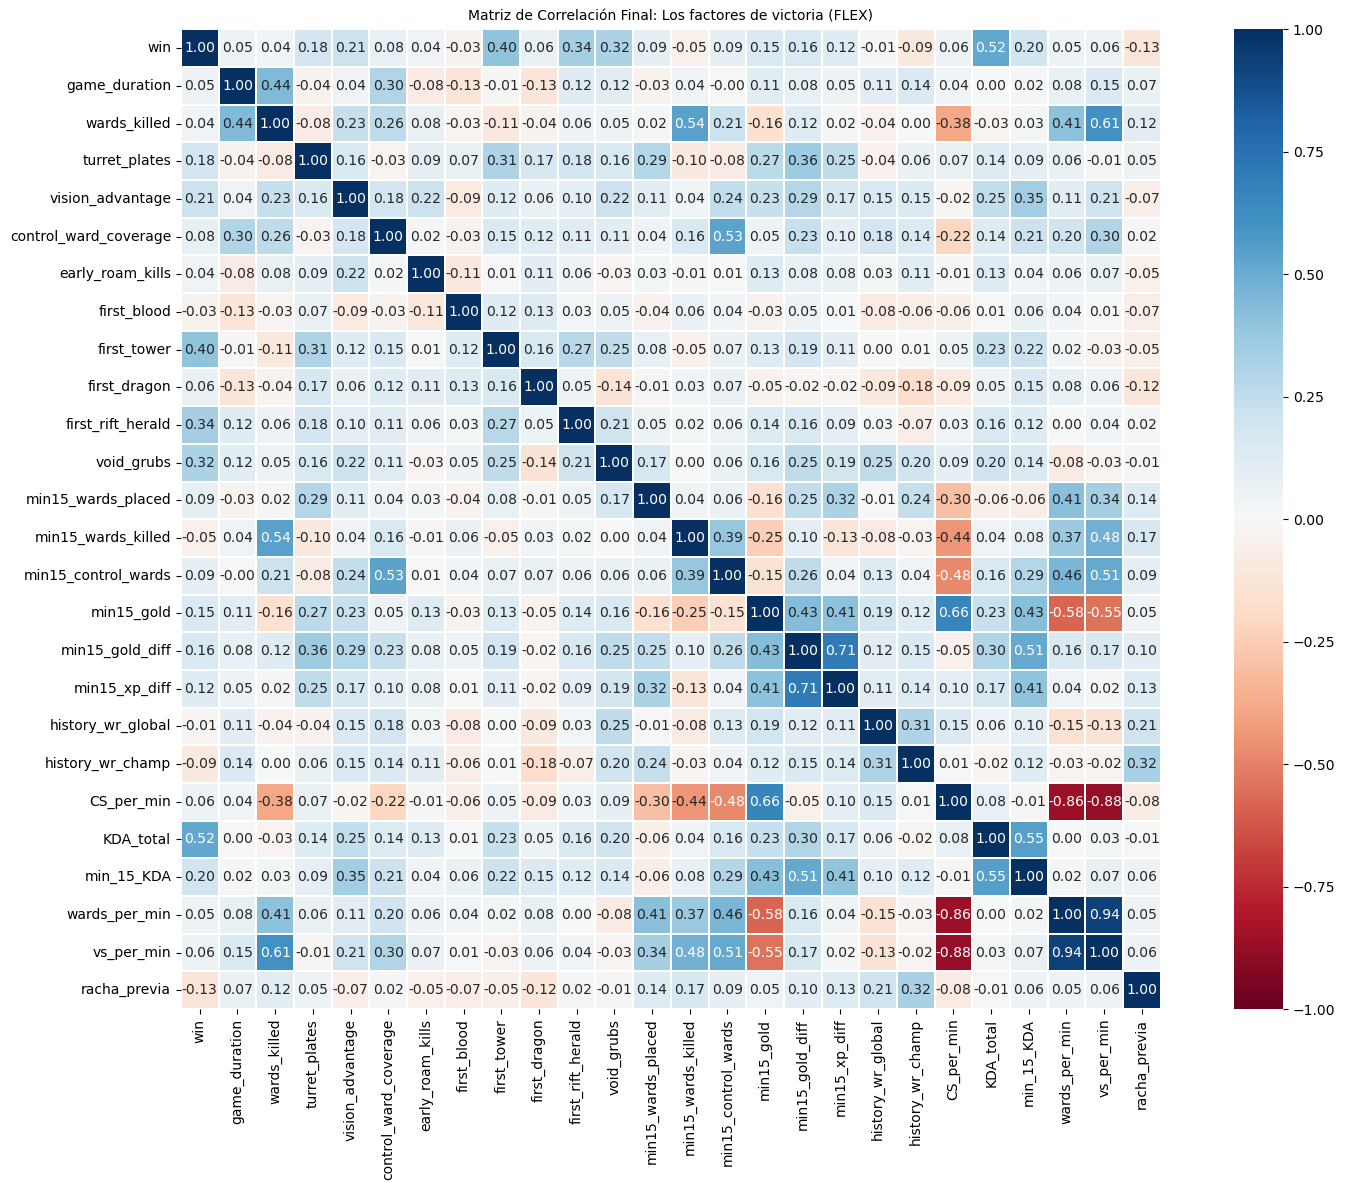

In [32]:
# 1. SELECCIÓN QUIRÚRGICA DE VARIABLES
# En lugar de borrar lo que sobra, elegimos a los titulares del equipo.
cols_to_exclude = [
    'champion',
    'role_JUNGLE',
    'role_TOP',
    'role_UTILITY',
    'role_MIDDLE',
    'is_flex',
    'match_num',
    'lane_minions',
    'jungle_minions',
    'assists_total',
    'deaths_total',
    'kills_total',
    'vision_score',
    'wards_placed',
    'control_wards_placed',
    'min15_kills',
    'min15_deaths',
    'min15_assists',
    'min15_cs',
    'min15_cs_diff',
    'total_wards_placed',
    'is_MMR_check'
]

cols_to_analyze = [c for c in df_analytics.columns if c not in cols_to_exclude]
# Filtro de seguridad: Solo usamos las columnas que existen en tu DF final
# (Usamos el DF unido para ver el panorama general)
cols_exist = [c for c in cols_to_analyze if c in df_analytics.columns]

# 2. CÁLCULO
# No necesitas escalar los datos para la correlación de Pearson.
corr_matrix = df_analytics_flex[cols_exist].corr()

# 3. VISUALIZACIÓN (HEATMAP PROFESIONAL)
plt.figure(figsize=(16,12))
sns.heatmap(
    corr_matrix, 
    annot=True,             # Muestra los números
    cmap='RdBu',            # Rojo=Te hace perder, Azul=Te hace ganar
    vmin=-1, vmax=1,        # Fijamos la escala entre -1 y 1
    fmt=".2f",              # 2 decimales
    linewidths=0.3,
    square=True
)
plt.title('Matriz de Correlación Final: Los factores de victoria (FLEX)', fontsize=10)
plt.tight_layout()
plt.show()

In [33]:
# Ranking impacto de variables en el target
print("--- RANKING DE IMPACTO EN LA VICTORIA (FLEX): ¿Relación directa o inversa? (Ayuda + / - Perjudica)  ---")
print(corr_matrix['win'].drop('win').sort_values(ascending=False))

--- RANKING DE IMPACTO EN LA VICTORIA (FLEX): ¿Relación directa o inversa? (Ayuda + / - Perjudica)  ---
KDA_total                0.519425
first_tower              0.399623
first_rift_herald        0.341653
void_grubs               0.315063
vision_advantage         0.211104
min_15_KDA               0.201404
turret_plates            0.181376
min15_gold_diff          0.164010
min15_gold               0.150857
min15_xp_diff            0.117342
min15_wards_placed       0.090123
min15_control_wards      0.088279
control_ward_coverage    0.079299
first_dragon             0.064369
vs_per_min               0.058624
CS_per_min               0.056574
game_duration            0.054026
wards_per_min            0.052867
early_roam_kills         0.043699
wards_killed             0.035199
history_wr_global       -0.014057
first_blood             -0.032982
min15_wards_killed      -0.054002
history_wr_champ        -0.094291
racha_previa            -0.128567
Name: win, dtype: float64


**Observaciones FLEX**

Las variables que generan más impacto en el target son:
- **KDA (relación directa):** Con un R =  0.51. Mientras aumente el KDA, aumentan las victorias. Al considerar el total ( a diferencia de KDA al min 15 con R=0.20) sabemos que no solo el early importa, sino que también lo que sucede en mid y late game.
- **first_tower (relación directa):** Con un R =  0.40. Mientras se destruya la primera torre, aumenta la probabilidad de victoria.     
- **first_rift_herald  (relación directa):** Con un R =  0.34. Mientras se asesine al heraldo, aumenta la probabilidad de victoria. (existe una correlación moderada entre la primera torre y heraldo, lo que significa que o la primera torre puede significar que se obtiene el heraldo con mayor facilidad o que al obtener el heraldo tirar la primera torre es más sencillo).
- **Voids Grabs:** Incide con un 0.30 en el target, lo que tiene sentido dado que ayuda a tirar torres más rapido y a obtener más placas de torres, lo que, por cierto, tienen correlación moderada positiva (0,25 con primera torre y 0.16 con las placas de torre).

**No existen variables que perjudiquen sustancialmente las victorias en FLEX (corr. entre -0,13 y 0).**

**Sinergia (Economía-Combate)**: Se observa una correlación moderada (r=0.56) entre la ventaja de oro temprana y el KDA final en SoloQ, superior a la observada en Flex (r=0.51). Esto sugiere que en el entorno individual (SoloQ), la capacidad del jugador para convertir el oro (gold_diff) en mejor rendimiento de combate (kda) es más directa y crítica para el resultado. En Flex, esta relación se debilita, indicando que el desempeño de combate depende más de la coordinación grupal que de la ventaja de recursos individual.

### Análisis de correlaciones: SOLOQ

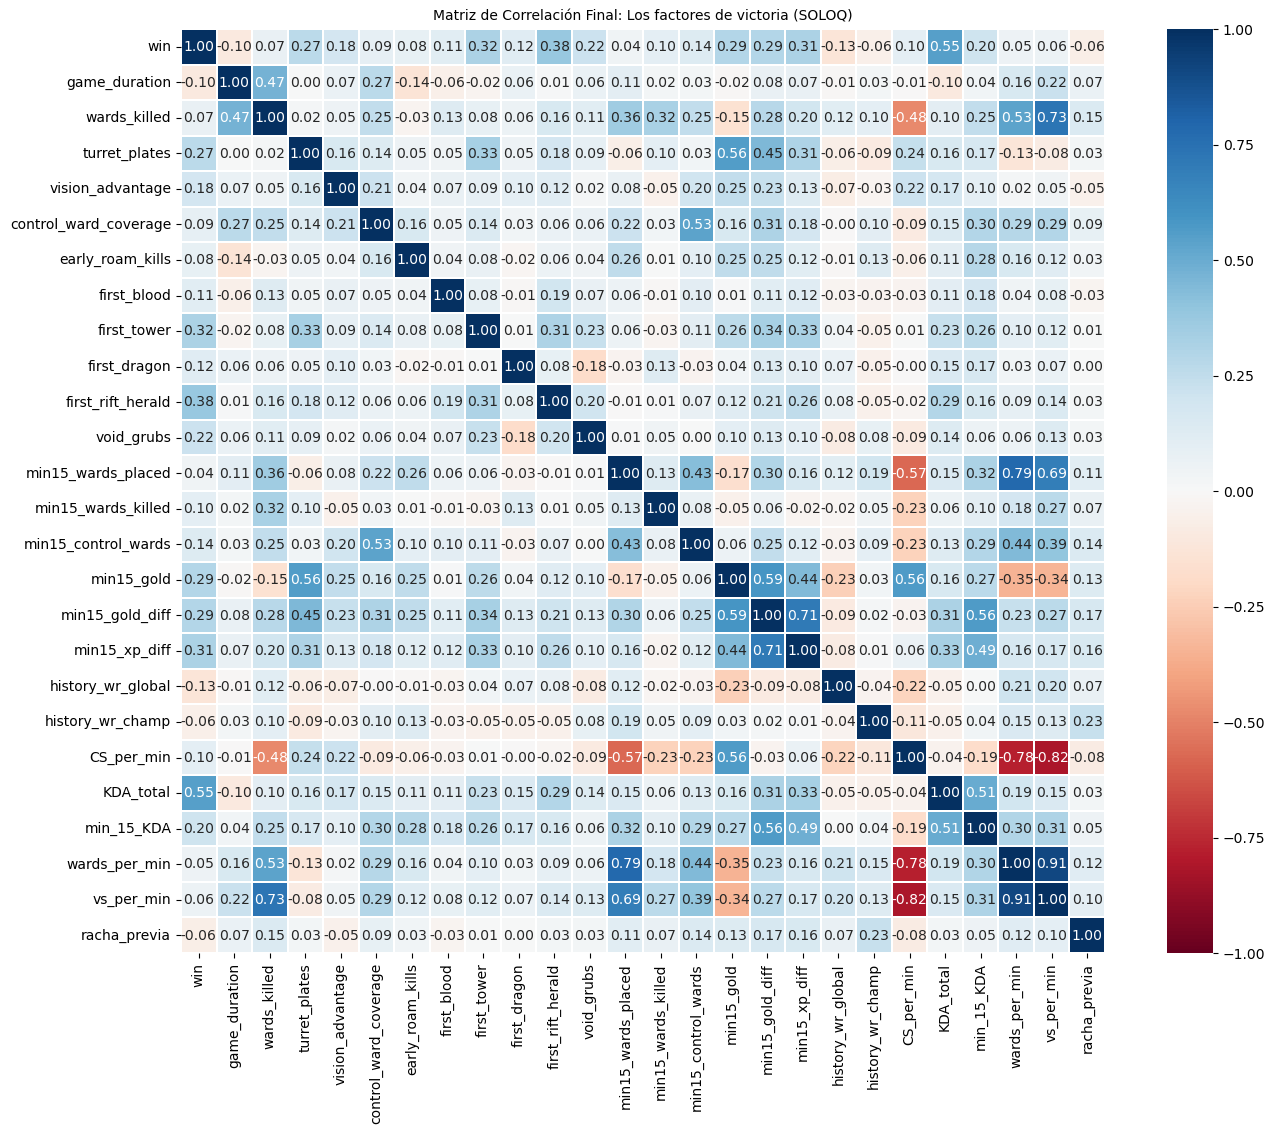

In [34]:
corr_matrix = df_analytics_soloq[cols_exist].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix, 
    annot=True,             # Muestra los números
    cmap='RdBu',            # Rojo=Te hace perder, Azul=Te hace ganar
    vmin=-1, vmax=1,        # Fijamos la escala entre -1 y 1
    fmt=".2f",              # 2 decimales
    linewidths=0.3,
    square=True
)
plt.title('Matriz de Correlación Final: Los factores de victoria (SOLOQ)', fontsize=10)
plt.show()

In [35]:
# Ranking impacto de variables en el target
print("--- RANKING DE IMPACTO EN LA VICTORIA (SOLO Q): ¿Relación directa o inversa? (Ayuda + / - Perjudica)  ---")
print(corr_matrix['win'].drop('win').sort_values(ascending=False))

--- RANKING DE IMPACTO EN LA VICTORIA (SOLO Q): ¿Relación directa o inversa? (Ayuda + / - Perjudica)  ---
KDA_total                0.551309
first_rift_herald        0.376067
first_tower              0.315340
min15_xp_diff            0.312668
min15_gold_diff          0.294149
min15_gold               0.289176
turret_plates            0.269327
void_grubs               0.215865
min_15_KDA               0.204576
vision_advantage         0.181486
min15_control_wards      0.135347
first_dragon             0.124417
first_blood              0.114729
min15_wards_killed       0.098744
CS_per_min               0.097374
control_ward_coverage    0.092121
early_roam_kills         0.084295
wards_killed             0.070726
vs_per_min               0.055598
wards_per_min            0.048601
min15_wards_placed       0.041491
history_wr_champ        -0.055590
racha_previa            -0.064094
game_duration           -0.101119
history_wr_global       -0.131467
Name: win, dtype: float64


**Observaciones SOLO Q**

Las variables que generan más impacto en el target son:
- **KDA (relación directa):** Con un R =  0.52. Mientras aumente el KDA, aumentan las victorias. Al considerar el total ( a diferencia de KDA al min 15 con R=0.20) sabemos que no solo el early importa, sino que también lo que sucede en mid y late game.
- **first_rift_herald  (relación directa):** Con un R =  0.36. Mientras se asesine al heraldo, aumenta la probabilidad de victoria.
- **first_tower (relación directa):** Con un R =  0.35. Mientras se destruya la primera torre, aumenta la probabilidad de victoria. (aumenta la correlación entre el heraldo y primera torre)
- - **Voids Grabs:** Al igual que en Flex, existe una correlación ganar. Pero baja la correlación con obtener placas de torre y para tirar la primera torre, lo que tiene sentido si el heraldo obtiene más importancia para tirarla.

A diferencia de Flex, en Solo Q es más relevante el asesinato del heraldo que tirar la primera torre en relación al target. 

**No existen variables que perjudiquen sustancialmente las victorias en Solo Q (corr. entre -0,13 y 0).**

- **Sinergia (Economía-Combate)**: Se observa una correlación moderada (r=0.55) entre la ventaja de oro temprana y el KDA final en SoloQ, superior a la observada en Flex (r=0.51). Esto sugiere que en el entorno individual (SoloQ), la capacidad del jugador para convertir el oro (gold_diff) en mejor rendimiento de combate (kda) es más directa y crítica para el resultado. En Flex, esta relación se debilita, indicando que el desempeño de combate depende más de la coordinación grupal que de la ventaja de recursos individual.

# 📊 Conclusión: DIAGNÓSTICO COMPETITIVO

A partir del análisis descriptivo y de comportamiento realizado sobre mis partidas, he construido mi perfil competitivo actual, identificando tres pilares críticos que definen mi estancamiento o potencial de ascenso:

### 1. Auditoría gestión de recursos de visión
Detecté una **asimetría crítica** entre mi inversión en visión y el win ratio:
* **En Flex Queue:** Identifiqué una visión ineficiente. Estoy invirtiendo en visión muy por encima del estándar de Diamante/Master. Esta inversión tiene un **Retorno Nulo ($p > 0.05$)** en mis victorias. **Mi Diagnóstico:** Estoy desperdiciando oro en visión que no estoy aprovechando, lo que retrasa mis picos de poder de combate.
* **En Solo Queue:** Mi estrategia de "Calidad sobre Cantidad" funciona en rol de Soporte, pero descubrí un **Superávit Estructural en el resto de roles**, donde mi volumen es muy superior al estándar competitivo, afectando negativamente mi control de mapa en un entorno donde la visión sí probó ser significativa para mí **($p > 0.01$)**.

Aun así, en general, la cantidad y la calidad son significativas. Por lo que mejorar ambas métricas en ambas colas debe ser prioritario.

### 2. Auditoría elección champion pool y roles main (SOLOQ y FLEX)
* **Roles main y champion pool:** Enfócate en los roles de Mid (Leblanc, Malzahar y Ahri) y Soporte (Thresh) en SoloQ; en caso de ir jungla solo usa Trundle. En Flex, Jungla o Top: Sejuani y Malphite (buena proyección). En cualquier caso, evita a toda costa el rol de soporte en Flex y si llegases a ir ADC, solo usa Ezreal. Estos picks me permitirán mejorar mis win ratios y romper la resistencia del matchmaking.

### 3. La Barrera del matchmaking (el "muro de habilidad")
Mi análisis de elasticidad de Matchmaking desmintió la existencia de una "Loss Queue" punitiva en Flex; luego de 2 derrotas el sistema intenta ayudar en recuperar tu MMR. Sin embargo, en SoloQ esto ocurre un poco diferente: se presenta un "salvavidas" ante 2 derrotas consecutivas pero en caso de perder, la probabilidad de ganar baja abruptamente en los siguientes 2 juegos. Por otro lado, el análisis confirma que me enfrento a un **Techo de Habilidad Rígido** luego de una racha de 3 victorias consecutivas, pero al pasar este techo, la probabilidad de ganar es mucho más alta.

* **El fenómeno de la racha de 3:** Tras una racha de 3 victorias consecutivas, mi rendimiento individual no decae abruptamente (KDA) pero sí colapsa ante variables como el oro y el XP. El aumento de MMR me pone a un mejor rival en frente pero no me gana a mí especialmente, sino por rotaciones, lecturas mejores de macrogame o aprovechando mejor los errores de mi equipo.
* **La causa:** El aumento de MMR me pone a un mejor rival en frente pero no me gana a mí especialmente, sino por rotaciones, lecturas mejores de macrogame o aprovechando mejor los errores de mi equipo.
* **Juego estratégico en racha +3:** Luego de la 3ra victoria consecutiva, lo más recomendable es jugar de manera inteligente, crea jugadas con mejor lectura de macrogame, no es necesario matar al rival en línea, debes generar un mayor impacto en el mapa más que en la línea.

### 4. Matriz de Correlación
El análisis de correlación reveló lo siguiente:

1.  **En SoloQ:** Mis juegos se deciden en los primeros 15 minutos. La estrategia óptima es **Agresiva/Snowball**. Debo priorizar campeones de *Early/Mid Game* que puedan ganar línea y convertir ese oro en KDA rápidamente, ya que el sistema no perdona las desventajas económicas y de XP.

2.  **En Flex:** El juego es permisivo. La estrategia óptima es **Coordinada/Scaling**. Puedo permitirme perder línea levemente si eso garantiza mejores peleas de equipo (*Teamfighting*) tarde, ya que el oro temprano no dicta la sentencia final.

3.  En ambas colas priorizar el heraldo y la primera torre. Luego del KDA, ambos objetivos son los que más inciden en la victoria.

4.  **Gestión de Expectativas:** Debo asumir que tras una racha positiva, la siguiente partida tendrá una probabilidad base de victoria menor debido al ajuste de MMR. En esos casos asume que tus probabilidades son más bajas, pero juega inteligente, aprovecha los errores del rival y, en caso de perder, no te preocupes, toma un descanso y juega nuevamente; tener una racha de derrotas luego de un MMR Check no es común.


---